# install packages

In [1]:
!pip install datasets
!pip install spacy
!pip install transformers
!pip install hazm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install sentencepiece

# import packages

In [3]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset,DataLoader
from typing import Iterable, List
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import random
from transformers import AutoTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from transformers import MBartTokenizer

#Download dataset

In [4]:
from datasets import load_dataset

# Load the Global Voices English-Persian translation dataset
dataset = load_dataset("persiannlp/parsinlu_translation_en_fa", split='train')

# Print a sample of the dataset
print("Sample English-Persian sentence pair:")
print(dataset[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.39k [00:00<?, ?B/s]

parsinlu_translation_en_fa.py:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

parsinlu-repo/validation/0000.parquet:   0%|          | 0.00/242k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1621665 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/48359 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2137 [00:00<?, ? examples/s]

Sample English-Persian sentence pair:
{'source': 'Due Thank You note by Egyptian blogger Abdel Monem Mahmoud: Following his release from prison, he wrote his first blog titled “Ana ikhwan… I am free”.', 'targets': ['بلاگر مصری عبدل منعم محمود (عربی) پس از آزاد شدنش از زندان تیتر اولین مطلب خود را «من آزاد هستم» (عربی) انتخاب کرد.'], 'category': 'global_voices_en_fa'}


In [5]:
# Randomly sample 20,000 examples from the dataset
sample_size = 1600000
sampled_dataset = dataset.shuffle(seed=42).select(range(sample_size))

persian_sentences = [item['targets'][0] for item in sampled_dataset]

In [6]:
english_sentences = [item['source'] for item in sampled_dataset]

In [7]:
persian_sentences[:4]

['دل بدریا زد پرسید: خانم، این راسته؟',
 'که با آنکه کنار دماغه کشتی ایستاده بودیم',
 'وقتی که این بمیرد، چقدر راضی خواهم شد.',
 'بله ساني مثل تو .']

In [8]:
# Save sentences to a text file (BPE requires input in file format)
with open("persian_corpus.txt", "w", encoding="utf-8") as f:
    for sentence in persian_sentences:
        f.write(sentence + "\n")

# 1-1-tokenization

### 1. different tokenization

In [9]:
import spacy
from hazm import word_tokenize
from transformers import AutoTokenizer
from transformers import MBartTokenizer

# Sample Persian text
text_fa = "من در حال یادگیری پردازش زبان طبیعی هستم و عاشق هوش مصنوعی و پردازشگرها هستم"

# Word-based tokenization using Hazm
word_tokens = word_tokenize(text_fa)
print("توکن‌های مبتنی بر واژه (Hazm):", word_tokens)

# Tokenize with BERT (subword-based)
subword_based_tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
subword_tokens = subword_based_tokenizer.tokenize(text_fa)
print("توکن‌های مبتنی بر زیرواژه (Subword):", subword_tokens)


توکن‌های مبتنی بر واژه (Hazm): ['من', 'در', 'حال', 'یادگیری', 'پردازش', 'زبان', 'طبیعی', 'هستم', 'و', 'عاشق', 'هوش', 'مصنوعی', 'و', 'پردازشگرها', 'هستم']


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


توکن‌های مبتنی بر زیرواژه (Subword): ['▁من', '▁در', '▁حال', '▁یادگیری', '▁پرداز', 'ش', '▁زبان', '▁طبیعی', '▁هستم', '▁و', '▁عاشق', '▁هوش', '▁مصنوعی', '▁و', '▁پرداز', 'ش', 'گر', 'ها', '▁هستم']


### 2.Train a sentencepiece tokenizer for persian

In [10]:
import sentencepiece as spm

# Path to the corpus file
corpus_file = "/content/persian_corpus.txt"

# Set parameters for training the tokenizer
vocab_size = 21000  # Adjust the vocabulary size
character_coverage = 0.999 # Coverage of characters in the training data
model_prefix = "/content/persian_spm"  # Prefix for saving the model and vocab

# Train the SentencePiece model
spm.SentencePieceTrainer.train(
    input=corpus_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    character_coverage=character_coverage,
    model_type='bpe'
)


# end of your code

print("Training complete! Model saved as 'persian_spm.model' and vocab as 'persian_spm.vocab'")


Training complete! Model saved as 'persian_spm.model' and vocab as 'persian_spm.vocab'


### Examples

In [11]:
# Load the trained SentencePiece model
# if you did optional part you comment the next 2 lines
sp = spm.SentencePieceProcessor()
sp.load('/content/persian_spm.model')

# Tokenize a sample Persian sentence
sentence = "این یک جمله است."
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)

# Convert the tokens back to the sentence
decoded_sentence = sp.decode(tokens)
print("Decoded sentence:", decoded_sentence)


Tokenized sentence: ['▁این', '▁یک', '▁جمله', '▁است', '.']
Decoded sentence: این یک جمله است.


In [12]:
sentence = "پردازش تصویر"
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)


Tokenized sentence: ['▁پرداز', 'ش', '▁تصویر']


In [13]:
sentence = "من به درس خواندن علاقه دارم "
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)


Tokenized sentence: ['▁من', '▁به', '▁درس', '▁خواندن', '▁علاقه', '▁دارم']


In [14]:
sentence = "بانو حالتون چطوره؟"
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)


Tokenized sentence: ['▁بانو', '▁حالتون', '▁چطوره', '؟']


In [15]:
sentence = "من کتابها را دوست دارم"
tokens = sp.tokenize(sentence, out_type=str)
print("Tokenized sentence:", tokens)

Tokenized sentence: ['▁من', '▁کتابها', '▁را', '▁دوست', '▁دارم']


In [16]:
tokens[0:2]

['▁من', '▁کتابها']

In [17]:
sentence = "من به زبان فارسی صحبت میکنم"
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)

Tokenized sentence: ['▁من', '▁به', '▁زبان', '▁فارسی', '▁صحبت', '▁میکنم']


In [18]:
sentence = "من در حال یادگیری پردازش زبان طبیعی هستم و عاشق هوش مصنوعی و پردازشگرها هستم"
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)

Tokenized sentence: ['▁من', '▁در', '▁حال', '▁یادگیری', '▁پرداز', 'ش', '▁زبان', '▁طبیعی', '▁هستم', '▁و', '▁عاشق', '▁هوش', '▁مصنوعی', '▁و', '▁پرداز', 'ش', 'گرها', '▁هستم']


#Pre-train a persian tokenizer

In [19]:
from gensim.models import Word2Vec

# Tokenized Persian sentences (list of lists of tokens)
tokenized_sentences = [word_tokenize(sentence) for sentence in persian_sentences]
vector_size=300
window=5
min_count=3
workers=4
# Train Word2Vec
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers
)

# Save the Word2Vec model
word2vec_model.save("word2vec_persian.model")

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your trained Word2Vec model
model = Word2Vec.load("/content/word2vec_persian.model")

## 1. Check most similar words

In [21]:

def most_similar_words(word):
    try:
        similar_words = model.wv.most_similar(word, topn=10)
        print(f"Most similar words to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"'{word}' not in vocabulary!")

# Test with an example word
most_similar_words("خوب")



Most similar words to 'خوب':
  خب: 0.6603
  بهتر: 0.5799
  بد: 0.5559
  خوب‌: 0.5425
  خوبه: 0.4886
  پرتنش: 0.4661
  خب,: 0.4597
  قشنگ: 0.4554
  یوریش: 0.4548
  معشوف: 0.4516


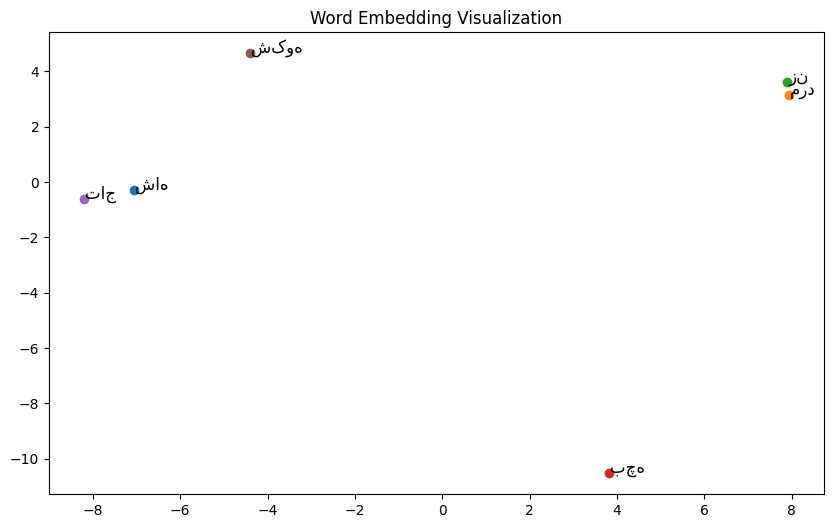

In [22]:

# 3. Visualize embeddings using PCA
def visualize_embeddings(words):
    try:
        word_vectors = [model.wv[word] for word in words]
        pca = PCA(n_components=2)
        reduced_vectors = pca.fit_transform(word_vectors)

        plt.figure(figsize=(10, 6))
        for word, vector in zip(words, reduced_vectors):
            plt.scatter(vector[0], vector[1])
            plt.text(vector[0] + 0.02, vector[1] + 0.02, word, fontsize=12)
        plt.title("Word Embedding Visualization")
        plt.show()
    except KeyError as e:
        print(f"Error: {e}")

# Test visualization with example words
words_to_visualize = ["شاه", "مرد", "زن", "بچه", "تاج", "شکوه"]
visualize_embeddings(words_to_visualize)

#Pre-train a english tokenizer

In [23]:
from gensim.models import Word2Vec

mb = MBartTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# Tokenized Persian sentences (list of lists of tokens)
tokenized_sentences = [mb.tokenize(sentence) for sentence in english_sentences]
vector_size=300
window=5
min_count=3
workers=4

# Train Word2Vec
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers
)
# Save the Word2Vec model
word2vec_model.save("word2vec_english.model")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


## 1. Check most similar words

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your trained Word2Vec model
model = Word2Vec.load("/content/word2vec_english.model")


def most_similar_words(word):
    try:
        similar_words = model.wv.most_similar(word, topn=10)
        print(f"Most similar words to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"'{word}' not in vocabulary!")

# Test with an example word
most_similar_words("man")

Most similar words to 'man':
  men: 0.5970
  ifs: 0.4044
  ▁gentleman: 0.3987
  ▁End: 0.3914
  mans: 0.3791
  sman: 0.3659
  ▁dealer: 0.3504
  ▁officer: 0.3436
  keeper: 0.3434
  ▁porter: 0.3405


## 3. Visualize embeddings using PCA

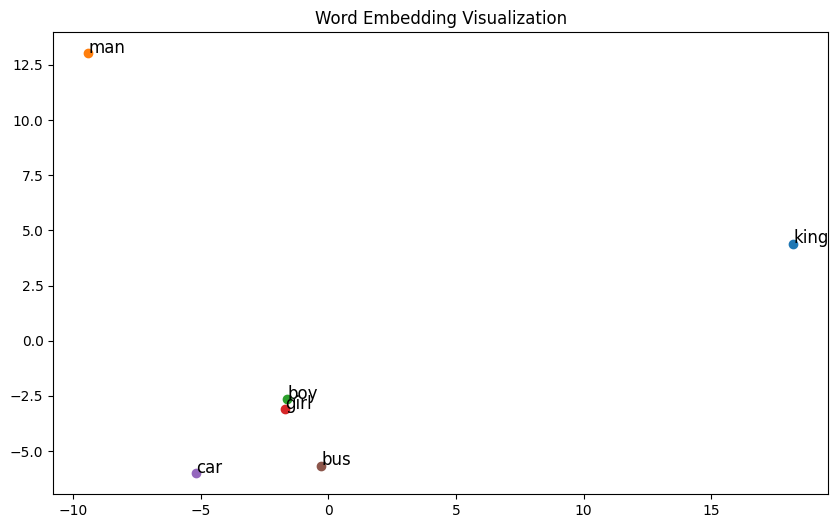

In [25]:

def visualize_embeddings(words):
    try:
        word_vectors = [model.wv[word] for word in words]
        pca = PCA(n_components=2)
        reduced_vectors = pca.fit_transform(word_vectors)

        plt.figure(figsize=(10, 6))
        for word, vector in zip(words, reduced_vectors):
            plt.scatter(vector[0], vector[1])
            plt.text(vector[0] + 0.02, vector[1] + 0.02, word, fontsize=12)
        plt.title("Word Embedding Visualization")
        plt.show()
    except KeyError as e:
        print(f"Error: {e}")

# Test visualization with example words
words_to_visualize = ["king", "man", "boy","girl","car","bus"]
visualize_embeddings(words_to_visualize)